In [1]:
# MIT License

# Copyright (c) [2019] [Jayden Booth]

# Permission is hereby granted, free of charge, to any person obtaining a copy
# of this software and associated documentation files (the "Software"), to deal
# in the Software without restriction, including without limitation the rights
# to use, copy, modify, merge, publish, distribute, sublicense, and/or sell
# copies of the Software, and to permit persons to whom the Software is
# furnished to do so, subject to the following conditions:

# The above copyright notice and this permission notice shall be included in all
# copies or substantial portions of the Software.

# THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
# IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
# FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE
# AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
# LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM,
# OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE
# SOFTWARE.

# Import Libraries
import numpy as np
import tensorflow as tf
import keras
from keras.layers import Input, Dense, GaussianNoise,Lambda,Dropout, Concatenate
from keras.models import Model
from keras import regularizers
from keras.layers.normalization import BatchNormalization
from keras.optimizers import Adam,SGD
from keras import backend as K
from keras.constraints import max_norm
%matplotlib inline
import matplotlib.pyplot as plt
from scipy import interpolate
from scipy import special

Using TensorFlow backend.


In [2]:
# Set random seeds
from numpy.random import seed
seed(1)
from tensorflow import set_random_seed
set_random_seed(3)

In [3]:
# Set the defining parameters
# n = n_channel complex numbers (so 2n real numbers)
# k = log2(M), where M is the number of messages to encode
# EbNo is the energy per bit to noise power density

# Encoder Parameters
M = 16
k = np.log2(M)
n_channel = 1
R = k/n_channel

#Power splitting ratio
rho = 0
eps=1
eta=1
print('number of symbols:',M)



number of symbols: 16


In [4]:
def set_up_train_nn(P):
    label = np.random.randint(M,size=N)

    # creating one hot encoded vectors
    data = []
    for i in label:
        temp = np.zeros(M)
        temp[i] = 1
        data.append(temp)

    # checking data shape
    data = np.array(data)
    print (data.shape)


    # Defined Autoencoder
    batch_size = 4096
    
    # Transmitter Layers
    input_signal = Input(shape=(M,))
    encoded = Dense(M, activation='relu')(input_signal)
    encoded2 = Dense(8, activation='relu')(encoded)
    encoded2 = Dense(4, activation='relu')(encoded)
    encoded2 = Dense(2*n_channel, activation='linear')(encoded)

    # Normalize Power
    encoded3 = BatchNormalization(momentum=0,epsilon=1e-6,center=False,scale=False,axis=1)(encoded2)
    encoded3 = Lambda(lambda x: x*np.sqrt(P/2))(encoded3)

    # Slicing into CD and PD data, and applying noise

    cd_data = Lambda(lambda x: np.sqrt(rho)*np.sqrt(eps)*x)(encoded3)
    cd_data = Lambda(lambda x: x+K.random_normal_variable((32768*2,2), 0,np.sqrt(0.5))[0:tf.shape(x)[0],:])(cd_data)

    
    pd_data = Lambda(lambda x: K.expand_dims((1-rho)*eta*eps*K.sum(K.square(x),axis=1),axis=1))(encoded3)
    pd_data = Lambda(lambda x: x+K.random_normal_variable((32768*2,1), 0,np.sqrt(1))[0:tf.shape(x)[0]])(pd_data)

    #combining the split data to feed the decoder
    data_split=[]
    data_split.append(cd_data)
    data_split.append(pd_data)

    data_split =  Concatenate(axis=1)(data_split)


    # Reciever Layer
    decoded = Dense(2, activation='linear')(data_split)
    decoded = Dense(4, activation='relu')(decoded)
    decoded = Dense(8, activation='relu')(decoded)
    decoded1 = Dense(M, activation='softmax')(decoded)
    autoencoder = Model(input_signal, decoded1)

    adam = Adam(lr=0.075)
    sgd = SGD(lr=0.5)
    autoencoder.compile(optimizer=adam, loss='categorical_crossentropy',metrics=['accuracy','mse'])

    # printing summary of layers and it's trainable parameters 
    print (autoencoder.summary())

    # traning auto encoder
    autoencoder.fit(data, data,
                    epochs=200,
                    batch_size=batch_size)

    # making encoder from full autoencoder
    encoder = Model(input_signal, encoded3)

    # for plotting learned consteallation diagram

    scatter_plot = []
    for i in range(0,M):
        temp = np.zeros(M)
        temp[i] = 1
        scatter_plot.append(encoder.predict(np.expand_dims(temp,axis=0)))
    scatter_plot = np.array(scatter_plot)
    print (scatter_plot.shape)

    # ploting constellation diagram
    import matplotlib.pyplot as plt
    scatter_plot = scatter_plot.reshape(M,2,1)

    plt.scatter(scatter_plot[:,0],scatter_plot[:,1])
    #plt.axis((-2,2,-2,2))
    plt.grid()
    #plt.title('Splitting Receiver: rho = '+str(rho)+' eps = '+str(eps))
    plt.xlabel('I Axis')
    plt.ylabel('Q Axis')
    plt.show()
    p_av = np.sum(np.square(scatter_plot),axis=1)
    print(sum(p_av)/16)

    return autoencoder

(16000, 16)
Instructions for updating:
Colocations handled automatically by placer.
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 16)           0                                            
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 16)           272         input_1[0][0]                    
__________________________________________________________________________________________________
dense_4 (Dense)                 (None, 2)            34          dense_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 2)            4           dense_4[0][0]                    
_________________________

16000/16000 [==============================] - 0s 5us/step - loss: 1.0011 - acc: 0.5040 - mean_squared_error: 0.0363
Epoch 34/200
16000/16000 [==============================] - 0s 4us/step - loss: 0.9459 - acc: 0.5736 - mean_squared_error: 0.0322
Epoch 35/200
16000/16000 [==============================] - 0s 4us/step - loss: 1.0139 - acc: 0.5177 - mean_squared_error: 0.0355
Epoch 36/200
16000/16000 [==============================] - 0s 5us/step - loss: 0.9068 - acc: 0.5500 - mean_squared_error: 0.0319
Epoch 37/200
16000/16000 [==============================] - 0s 5us/step - loss: 0.8467 - acc: 0.6254 - mean_squared_error: 0.0299
Epoch 38/200
16000/16000 [==============================] - 0s 5us/step - loss: 0.7915 - acc: 0.6492 - mean_squared_error: 0.0286
Epoch 39/200
16000/16000 [==============================] - 0s 6us/step - loss: 0.8427 - acc: 0.5739 - mean_squared_error: 0.0303
Epoch 40/200
16000/16000 [==============================] - 0s 5us/step - loss: 0.8183 - acc: 0.6117 - 

16000/16000 [==============================] - 0s 5us/step - loss: 0.7288 - acc: 0.6774 - mean_squared_error: 0.0263
Epoch 97/200
16000/16000 [==============================] - 0s 6us/step - loss: 0.6680 - acc: 0.6919 - mean_squared_error: 0.0262
Epoch 98/200
16000/16000 [==============================] - 0s 6us/step - loss: 0.7327 - acc: 0.6165 - mean_squared_error: 0.0285
Epoch 99/200
16000/16000 [==============================] - 0s 6us/step - loss: 0.8029 - acc: 0.6485 - mean_squared_error: 0.0288
Epoch 100/200
16000/16000 [==============================] - 0s 6us/step - loss: 0.6318 - acc: 0.6824 - mean_squared_error: 0.0247
Epoch 101/200
16000/16000 [==============================] - 0s 6us/step - loss: 0.5609 - acc: 0.7258 - mean_squared_error: 0.0217
Epoch 102/200
16000/16000 [==============================] - 0s 5us/step - loss: 0.5401 - acc: 0.7663 - mean_squared_error: 0.0199
Epoch 103/200
16000/16000 [==============================] - 0s 6us/step - loss: 0.5181 - acc: 0.784

16000/16000 [==============================] - 0s 6us/step - loss: 0.4052 - acc: 0.8191 - mean_squared_error: 0.0153
Epoch 159/200
16000/16000 [==============================] - 0s 5us/step - loss: 0.4372 - acc: 0.8043 - mean_squared_error: 0.0165
Epoch 160/200
16000/16000 [==============================] - 0s 6us/step - loss: 0.5088 - acc: 0.7769 - mean_squared_error: 0.0194
Epoch 161/200
16000/16000 [==============================] - 0s 6us/step - loss: 0.5911 - acc: 0.7484 - mean_squared_error: 0.0214
Epoch 162/200
16000/16000 [==============================] - 0s 5us/step - loss: 0.5803 - acc: 0.7224 - mean_squared_error: 0.0227
Epoch 163/200
16000/16000 [==============================] - 0s 6us/step - loss: 0.4652 - acc: 0.8021 - mean_squared_error: 0.0178
Epoch 164/200
16000/16000 [==============================] - 0s 5us/step - loss: 0.4482 - acc: 0.8198 - mean_squared_error: 0.0165
Epoch 165/200
16000/16000 [==============================] - 0s 5us/step - loss: 0.4158 - acc: 0.

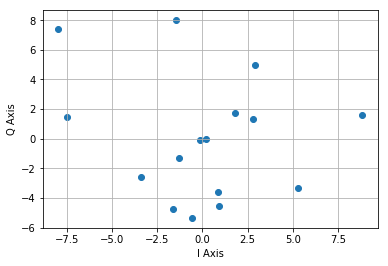

[32.656708]
Es/No: 12 SER: 0.1216875 Theor_SER_PAM: 0.5075803579279314
(65000, 16)
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 16)           0                                            
__________________________________________________________________________________________________
dense_9 (Dense)                 (None, 16)           272         input_2[0][0]                    
__________________________________________________________________________________________________
dense_12 (Dense)                (None, 2)            34          dense_9[0][0]                    
__________________________________________________________________________________________________
batch_normalization_2 (BatchNor (None, 2)            4           dense_12[0][0]                   
__________________________

65000/65000 [==============================] - 0s 4us/step - loss: 2.7732 - acc: 0.0629 - mean_squared_error: 0.0586
Epoch 38/200
65000/65000 [==============================] - 0s 4us/step - loss: 2.7730 - acc: 0.0629 - mean_squared_error: 0.0586
Epoch 39/200
65000/65000 [==============================] - 0s 4us/step - loss: 2.7733 - acc: 0.0633 - mean_squared_error: 0.0586
Epoch 40/200
65000/65000 [==============================] - 0s 4us/step - loss: 2.7734 - acc: 0.0628 - mean_squared_error: 0.0586
Epoch 41/200
65000/65000 [==============================] - 0s 4us/step - loss: 2.7733 - acc: 0.0645 - mean_squared_error: 0.0586
Epoch 42/200
65000/65000 [==============================] - 0s 4us/step - loss: 2.7734 - acc: 0.0630 - mean_squared_error: 0.0586
Epoch 43/200
65000/65000 [==============================] - 0s 3us/step - loss: 2.7733 - acc: 0.0632 - mean_squared_error: 0.0586
Epoch 44/200
65000/65000 [==============================] - 0s 4us/step - loss: 2.7732 - acc: 0.0631 - 

65000/65000 [==============================] - 0s 4us/step - loss: 2.7733 - acc: 0.0642 - mean_squared_error: 0.0586
Epoch 100/200
65000/65000 [==============================] - 0s 5us/step - loss: 2.7735 - acc: 0.0638 - mean_squared_error: 0.0586
Epoch 101/200
65000/65000 [==============================] - 0s 5us/step - loss: 2.7732 - acc: 0.0632 - mean_squared_error: 0.0586
Epoch 102/200
65000/65000 [==============================] - 0s 4us/step - loss: 2.7736 - acc: 0.0629 - mean_squared_error: 0.0586
Epoch 103/200
65000/65000 [==============================] - 0s 4us/step - loss: 2.7735 - acc: 0.0633 - mean_squared_error: 0.0586
Epoch 104/200
65000/65000 [==============================] - 0s 4us/step - loss: 2.7732 - acc: 0.0624 - mean_squared_error: 0.0586
Epoch 105/200
65000/65000 [==============================] - 0s 4us/step - loss: 2.7733 - acc: 0.0639 - mean_squared_error: 0.0586
Epoch 106/200
65000/65000 [==============================] - 0s 4us/step - loss: 2.7733 - acc: 0.

65000/65000 [==============================] - 0s 4us/step - loss: 2.7737 - acc: 0.0638 - mean_squared_error: 0.0586
Epoch 162/200
65000/65000 [==============================] - 0s 3us/step - loss: 2.7738 - acc: 0.0634 - mean_squared_error: 0.0586
Epoch 163/200
65000/65000 [==============================] - 0s 4us/step - loss: 2.7732 - acc: 0.0633 - mean_squared_error: 0.0586
Epoch 164/200
65000/65000 [==============================] - 0s 4us/step - loss: 2.7734 - acc: 0.0613 - mean_squared_error: 0.0586
Epoch 165/200
65000/65000 [==============================] - 0s 4us/step - loss: 2.7735 - acc: 0.0635 - mean_squared_error: 0.0586
Epoch 166/200
65000/65000 [==============================] - 0s 4us/step - loss: 2.7734 - acc: 0.0646 - mean_squared_error: 0.0586
Epoch 167/200
65000/65000 [==============================] - 0s 4us/step - loss: 2.7738 - acc: 0.0624 - mean_squared_error: 0.0586
Epoch 168/200
65000/65000 [==============================] - 0s 4us/step - loss: 2.7734 - acc: 0.

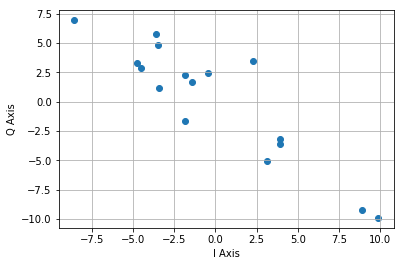

[48.149197]
Es/No: 14 SER: 0.9371538461538461 Theor_SER_PAM: 0.4143940207176103
(55000, 16)
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 16)           0                                            
__________________________________________________________________________________________________
dense_17 (Dense)                (None, 16)           272         input_3[0][0]                    
__________________________________________________________________________________________________
dense_20 (Dense)                (None, 2)            34          dense_17[0][0]                   
__________________________________________________________________________________________________
batch_normalization_3 (BatchNor (None, 2)            4           dense_20[0][0]                   
_________________

55000/55000 [==============================] - 0s 7us/step - loss: 1.7144 - acc: 0.3437 - mean_squared_error: 0.0414
Epoch 38/200
55000/55000 [==============================] - 0s 7us/step - loss: 1.6717 - acc: 0.3731 - mean_squared_error: 0.0394
Epoch 39/200
55000/55000 [==============================] - 0s 7us/step - loss: 1.6591 - acc: 0.3748 - mean_squared_error: 0.0391
Epoch 40/200
55000/55000 [==============================] - 0s 8us/step - loss: 1.6557 - acc: 0.3760 - mean_squared_error: 0.0390
Epoch 41/200
55000/55000 [==============================] - 0s 7us/step - loss: 1.6546 - acc: 0.3745 - mean_squared_error: 0.0390
Epoch 42/200
55000/55000 [==============================] - 0s 8us/step - loss: 1.6536 - acc: 0.3764 - mean_squared_error: 0.0390
Epoch 43/200
55000/55000 [==============================] - 0s 8us/step - loss: 1.6524 - acc: 0.3747 - mean_squared_error: 0.0390
Epoch 44/200
55000/55000 [==============================] - 0s 7us/step - loss: 1.6523 - acc: 0.3737 - 

55000/55000 [==============================] - 0s 7us/step - loss: 2.0794 - acc: 0.2515 - mean_squared_error: 0.0468
Epoch 101/200
55000/55000 [==============================] - 0s 6us/step - loss: 2.0794 - acc: 0.2525 - mean_squared_error: 0.0468
Epoch 102/200
55000/55000 [==============================] - 0s 5us/step - loss: 2.0795 - acc: 0.2518 - mean_squared_error: 0.0468
Epoch 103/200
55000/55000 [==============================] - 0s 5us/step - loss: 2.0794 - acc: 0.2505 - mean_squared_error: 0.0468
Epoch 104/200
55000/55000 [==============================] - 0s 7us/step - loss: 2.0793 - acc: 0.2524 - mean_squared_error: 0.0468
Epoch 105/200
55000/55000 [==============================] - 0s 7us/step - loss: 2.0794 - acc: 0.2510 - mean_squared_error: 0.0468
Epoch 106/200
55000/55000 [==============================] - 0s 6us/step - loss: 2.0795 - acc: 0.2503 - mean_squared_error: 0.0468
Epoch 107/200
55000/55000 [==============================] - 0s 5us/step - loss: 2.0792 - acc: 0.

55000/55000 [==============================] - 0s 8us/step - loss: 2.3070 - acc: 0.1874 - mean_squared_error: 0.0507
Epoch 163/200
55000/55000 [==============================] - 0s 8us/step - loss: 2.3069 - acc: 0.1904 - mean_squared_error: 0.0507
Epoch 164/200
55000/55000 [==============================] - 0s 6us/step - loss: 2.3075 - acc: 0.1878 - mean_squared_error: 0.0507
Epoch 165/200
55000/55000 [==============================] - 0s 6us/step - loss: 2.3073 - acc: 0.1879 - mean_squared_error: 0.0507
Epoch 166/200
55000/55000 [==============================] - 0s 7us/step - loss: 2.3072 - acc: 0.1876 - mean_squared_error: 0.0507
Epoch 167/200
55000/55000 [==============================] - 0s 7us/step - loss: 2.3071 - acc: 0.1878 - mean_squared_error: 0.0507
Epoch 168/200
55000/55000 [==============================] - 0s 7us/step - loss: 2.3072 - acc: 0.1878 - mean_squared_error: 0.0507
Epoch 169/200
55000/55000 [==============================] - 0s 8us/step - loss: 2.3072 - acc: 0.

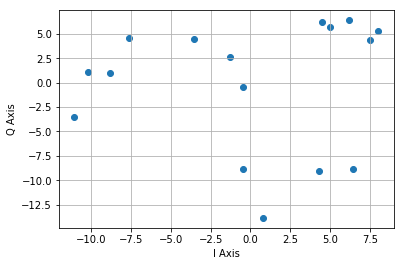

[80.803734]
Es/No: 16 SER: 0.8122909090909091 Theor_SER_PAM: 0.3123019621637889
(16000, 16)
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            (None, 16)           0                                            
__________________________________________________________________________________________________
dense_25 (Dense)                (None, 16)           272         input_4[0][0]                    
__________________________________________________________________________________________________
dense_28 (Dense)                (None, 2)            34          dense_25[0][0]                   
__________________________________________________________________________________________________
batch_normalization_4 (BatchNor (None, 2)            4           dense_28[0][0]                   
_________________

16000/16000 [==============================] - 0s 4us/step - loss: 2.5379 - acc: 0.1266 - mean_squared_error: 0.0546
Epoch 38/200
16000/16000 [==============================] - 0s 4us/step - loss: 2.5378 - acc: 0.1281 - mean_squared_error: 0.0546
Epoch 39/200
16000/16000 [==============================] - 0s 5us/step - loss: 2.5378 - acc: 0.1260 - mean_squared_error: 0.0546
Epoch 40/200
16000/16000 [==============================] - 0s 4us/step - loss: 2.5377 - acc: 0.1254 - mean_squared_error: 0.0546
Epoch 41/200
16000/16000 [==============================] - 0s 4us/step - loss: 2.5377 - acc: 0.1281 - mean_squared_error: 0.0546
Epoch 42/200
16000/16000 [==============================] - 0s 4us/step - loss: 2.5377 - acc: 0.1257 - mean_squared_error: 0.0546
Epoch 43/200
16000/16000 [==============================] - 0s 4us/step - loss: 2.5377 - acc: 0.1268 - mean_squared_error: 0.0546
Epoch 44/200
16000/16000 [==============================] - 0s 4us/step - loss: 2.5376 - acc: 0.1279 - 

16000/16000 [==============================] - 0s 4us/step - loss: 2.5367 - acc: 0.1281 - mean_squared_error: 0.0546
Epoch 101/200
16000/16000 [==============================] - 0s 3us/step - loss: 2.5367 - acc: 0.1266 - mean_squared_error: 0.0546
Epoch 102/200
16000/16000 [==============================] - 0s 3us/step - loss: 2.5367 - acc: 0.1255 - mean_squared_error: 0.0546
Epoch 103/200
16000/16000 [==============================] - 0s 3us/step - loss: 2.5369 - acc: 0.1278 - mean_squared_error: 0.0546
Epoch 104/200
16000/16000 [==============================] - 0s 4us/step - loss: 2.5368 - acc: 0.1278 - mean_squared_error: 0.0546
Epoch 105/200
16000/16000 [==============================] - 0s 3us/step - loss: 2.5367 - acc: 0.1275 - mean_squared_error: 0.0546
Epoch 106/200
16000/16000 [==============================] - 0s 4us/step - loss: 2.5367 - acc: 0.1281 - mean_squared_error: 0.0546
Epoch 107/200
16000/16000 [==============================] - 0s 4us/step - loss: 2.5367 - acc: 0.

16000/16000 [==============================] - 0s 4us/step - loss: 2.5366 - acc: 0.1261 - mean_squared_error: 0.0546
Epoch 163/200
16000/16000 [==============================] - 0s 4us/step - loss: 2.5366 - acc: 0.1281 - mean_squared_error: 0.0546
Epoch 164/200
16000/16000 [==============================] - 0s 6us/step - loss: 2.5365 - acc: 0.1281 - mean_squared_error: 0.0546
Epoch 165/200
16000/16000 [==============================] - 0s 3us/step - loss: 2.5365 - acc: 0.1281 - mean_squared_error: 0.0546
Epoch 166/200
16000/16000 [==============================] - 0s 3us/step - loss: 2.5365 - acc: 0.1278 - mean_squared_error: 0.0546
Epoch 167/200
16000/16000 [==============================] - 0s 4us/step - loss: 2.5366 - acc: 0.1269 - mean_squared_error: 0.0546
Epoch 168/200
16000/16000 [==============================] - 0s 4us/step - loss: 2.5367 - acc: 0.1256 - mean_squared_error: 0.0546
Epoch 169/200
16000/16000 [==============================] - 0s 3us/step - loss: 2.5366 - acc: 0.

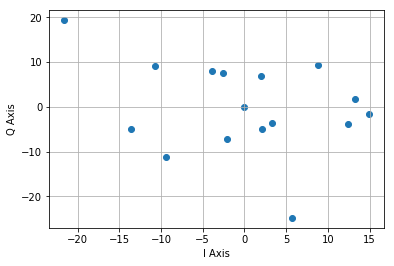

[197.50499]
Es/No: 20 SER: 0.8724375 Theor_SER_PAM: 0.11723145012290671
(14000, 16)
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            (None, 16)           0                                            
__________________________________________________________________________________________________
dense_33 (Dense)                (None, 16)           272         input_5[0][0]                    
__________________________________________________________________________________________________
dense_36 (Dense)                (None, 2)            34          dense_33[0][0]                   
__________________________________________________________________________________________________
batch_normalization_5 (BatchNor (None, 2)            4           dense_36[0][0]                   
_________________________

14000/14000 [==============================] - 0s 11us/step - loss: 15.1280 - acc: 0.0614 - mean_squared_error: 0.1173
Epoch 38/200
14000/14000 [==============================] - 0s 21us/step - loss: 15.1280 - acc: 0.0614 - mean_squared_error: 0.1173
Epoch 39/200
14000/14000 [==============================] - 0s 16us/step - loss: 15.1280 - acc: 0.0614 - mean_squared_error: 0.1173
Epoch 40/200
14000/14000 [==============================] - 0s 9us/step - loss: 15.1280 - acc: 0.0614 - mean_squared_error: 0.1173
Epoch 41/200
14000/14000 [==============================] - 0s 9us/step - loss: 15.1280 - acc: 0.0614 - mean_squared_error: 0.1173
Epoch 42/200
14000/14000 [==============================] - 0s 9us/step - loss: 15.1280 - acc: 0.0614 - mean_squared_error: 0.1173
Epoch 43/200
14000/14000 [==============================] - 0s 10us/step - loss: 15.1280 - acc: 0.0614 - mean_squared_error: 0.1173
Epoch 44/200
14000/14000 [==============================] - 0s 10us/step - loss: 15.1280 - a

14000/14000 [==============================] - 0s 10us/step - loss: 15.1280 - acc: 0.0614 - mean_squared_error: 0.1173
Epoch 100/200
14000/14000 [==============================] - 0s 11us/step - loss: 15.1280 - acc: 0.0614 - mean_squared_error: 0.1173
Epoch 101/200
14000/14000 [==============================] - 0s 11us/step - loss: 15.1280 - acc: 0.0614 - mean_squared_error: 0.1173
Epoch 102/200
14000/14000 [==============================] - 0s 11us/step - loss: 15.1280 - acc: 0.0614 - mean_squared_error: 0.1173
Epoch 103/200
14000/14000 [==============================] - 0s 10us/step - loss: 15.1280 - acc: 0.0614 - mean_squared_error: 0.1173
Epoch 104/200
14000/14000 [==============================] - 0s 13us/step - loss: 15.1280 - acc: 0.0614 - mean_squared_error: 0.1173
Epoch 105/200
14000/14000 [==============================] - 0s 12us/step - loss: 15.1280 - acc: 0.0614 - mean_squared_error: 0.1173
Epoch 106/200
14000/14000 [==============================] - 0s 10us/step - loss: 1

14000/14000 [==============================] - 0s 13us/step - loss: 15.1280 - acc: 0.0614 - mean_squared_error: 0.1173
Epoch 161/200
14000/14000 [==============================] - 0s 12us/step - loss: 15.1280 - acc: 0.0614 - mean_squared_error: 0.1173
Epoch 162/200
14000/14000 [==============================] - 0s 11us/step - loss: 15.1280 - acc: 0.0614 - mean_squared_error: 0.1173
Epoch 163/200
14000/14000 [==============================] - 0s 13us/step - loss: 15.1280 - acc: 0.0614 - mean_squared_error: 0.1173
Epoch 164/200
14000/14000 [==============================] - 0s 11us/step - loss: 15.1280 - acc: 0.0614 - mean_squared_error: 0.1173
Epoch 165/200
14000/14000 [==============================] - 0s 16us/step - loss: 15.1280 - acc: 0.0614 - mean_squared_error: 0.1173
Epoch 166/200
14000/14000 [==============================] - 0s 15us/step - loss: 15.1280 - acc: 0.0614 - mean_squared_error: 0.1173
Epoch 167/200
14000/14000 [==============================] - 0s 17us/step - loss: 1

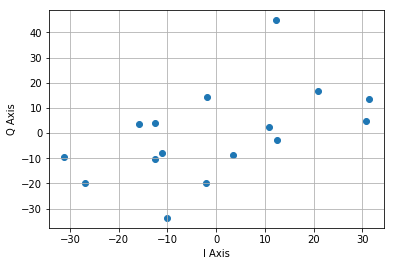

[643.4805]
Es/No: 25 SER: 0.9376428571428571 Theor_SER_PAM: 0.00597813169126268
(15000, 16)
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            (None, 16)           0                                            
__________________________________________________________________________________________________
dense_41 (Dense)                (None, 16)           272         input_6[0][0]                    
__________________________________________________________________________________________________
dense_44 (Dense)                (None, 2)            34          dense_41[0][0]                   
__________________________________________________________________________________________________
batch_normalization_6 (BatchNor (None, 2)            4           dense_44[0][0]                   
_________________

15000/15000 [==============================] - 0s 7us/step - loss: 2.7724 - acc: 0.0661 - mean_squared_error: 0.0586
Epoch 38/200
15000/15000 [==============================] - 0s 8us/step - loss: 2.7724 - acc: 0.0634 - mean_squared_error: 0.0586
Epoch 39/200
15000/15000 [==============================] - 0s 6us/step - loss: 2.7724 - acc: 0.0626 - mean_squared_error: 0.0586
Epoch 40/200
15000/15000 [==============================] - 0s 7us/step - loss: 2.7723 - acc: 0.0617 - mean_squared_error: 0.0586
Epoch 41/200
15000/15000 [==============================] - 0s 6us/step - loss: 2.7724 - acc: 0.0657 - mean_squared_error: 0.0586
Epoch 42/200
15000/15000 [==============================] - 0s 6us/step - loss: 2.7724 - acc: 0.0660 - mean_squared_error: 0.0586
Epoch 43/200
15000/15000 [==============================] - 0s 8us/step - loss: 2.7724 - acc: 0.0644 - mean_squared_error: 0.0586
Epoch 44/200
15000/15000 [==============================] - 0s 6us/step - loss: 2.7724 - acc: 0.0657 - 

15000/15000 [==============================] - 0s 5us/step - loss: 2.7727 - acc: 0.0633 - mean_squared_error: 0.0586
Epoch 101/200
15000/15000 [==============================] - 0s 5us/step - loss: 2.7724 - acc: 0.0660 - mean_squared_error: 0.0586
Epoch 102/200
15000/15000 [==============================] - 0s 5us/step - loss: 2.7726 - acc: 0.0657 - mean_squared_error: 0.0586
Epoch 103/200
15000/15000 [==============================] - 0s 6us/step - loss: 2.7728 - acc: 0.0609 - mean_squared_error: 0.0586
Epoch 104/200
15000/15000 [==============================] - 0s 6us/step - loss: 2.7724 - acc: 0.0644 - mean_squared_error: 0.0586
Epoch 105/200
15000/15000 [==============================] - 0s 5us/step - loss: 2.7724 - acc: 0.0660 - mean_squared_error: 0.0586
Epoch 106/200
15000/15000 [==============================] - 0s 5us/step - loss: 2.7724 - acc: 0.0655 - mean_squared_error: 0.0586
Epoch 107/200
15000/15000 [==============================] - 0s 6us/step - loss: 2.7725 - acc: 0.

15000/15000 [==============================] - 0s 4us/step - loss: 2.7726 - acc: 0.0649 - mean_squared_error: 0.0586
Epoch 163/200
15000/15000 [==============================] - 0s 6us/step - loss: 2.7726 - acc: 0.0611 - mean_squared_error: 0.0586
Epoch 164/200
15000/15000 [==============================] - 0s 4us/step - loss: 2.7726 - acc: 0.0672 - mean_squared_error: 0.0586
Epoch 165/200
15000/15000 [==============================] - 0s 5us/step - loss: 2.7724 - acc: 0.0660 - mean_squared_error: 0.0586
Epoch 166/200
15000/15000 [==============================] - 0s 4us/step - loss: 2.7724 - acc: 0.0660 - mean_squared_error: 0.0586
Epoch 167/200
15000/15000 [==============================] - 0s 5us/step - loss: 2.7726 - acc: 0.0643 - mean_squared_error: 0.0586
Epoch 168/200
15000/15000 [==============================] - 0s 5us/step - loss: 2.7724 - acc: 0.0657 - mean_squared_error: 0.0586
Epoch 169/200
15000/15000 [==============================] - 0s 6us/step - loss: 2.7725 - acc: 0.

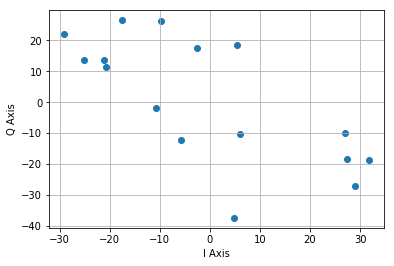

[784.28864]
Es/No: 26 SER: 0.9378666666666666 Theor_SER_PAM: 0.0020709317187892974


In [5]:
EsNodB_range = [12,14,16,20,25,26]
N_array=[16000,65000,55000,16000,14000,15000]
ser = [None]*len(EsNodB_range)
theor_ser_qam = [None]*len(EsNodB_range)
theor_ser = [None]*len(EsNodB_range)

noise_std = np.sqrt(2)
for n in range(0,len(EsNodB_range)):
    
    EsNo=10.0**(EsNodB_range[n]/10.0)
    P = EsNo*(noise_std**2)
    
    no_errors = 0
    
    N=N_array[n]
   
    
    autoencoder = set_up_train_nn(P)
    
    # generating data for checking SER
    test_label = np.random.randint(M,size=N)
    test_data = []

    for i in test_label:
        temp = np.zeros(M)
        temp[i] = 1
        test_data.append(temp)

    test_data = np.array(test_data)
    
    pred_final_signal = autoencoder.predict(test_data)
    
    pred_output = np.argmax(pred_final_signal,axis=1)
    no_errors = (pred_output != test_label)
    no_errors =  no_errors.astype(int).sum()
    ser[n] = no_errors / N 
    
    P_sqrtM = 0.75*special.erfc(np.sqrt(EsNo/10))
    theor_ser_qam[n] = 1-(1-P_sqrtM)**2
    theor_ser[n] = (15/16)*special.erfc(np.sqrt(EsNo/85))
    
    print ('Es/No:',EsNodB_range[n],'SER:',ser[n],'Theor_SER_PAM:',theor_ser[n])
    

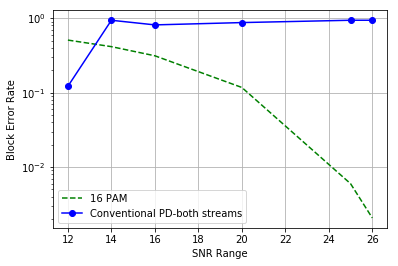

In [6]:
plt.plot(EsNodB_range, theor_ser, 'g--',label='16 PAM')
plt.plot(EsNodB_range, ser, 'bo-',label='Conventional PD-both streams')
plt.yscale('log')
plt.xlabel('SNR Range')
plt.ylabel('Block Error Rate')
plt.grid()
plt.legend(loc='best',ncol = 1)
plt.show()

In [7]:
ser

[0.1216875,
 0.9371538461538461,
 0.8122909090909091,
 0.8724375,
 0.9376428571428571,
 0.9378666666666666]